<a href="https://colab.research.google.com/github/agusrichard/data-science-projects/blob/master/Movies%20Recommendation/movies_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movies Recommendation

__Import Libraries__

In [1]:
# Essentials
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
plt.style.use('ggplot')
sns.set_palette('colorblind')

# Language Related
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


__Manual NLTK Downloads__

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

__Load Data__

In [3]:
!wget https://assets.datacamp.com/production/repositories/4375/datasets/83f27c4ad045c098d3db5596154316e4ee0a28a8/movie_overviews.csv

--2020-07-15 16:56:46--  https://assets.datacamp.com/production/repositories/4375/datasets/83f27c4ad045c098d3db5596154316e4ee0a28a8/movie_overviews.csv
Resolving assets.datacamp.com (assets.datacamp.com)... 13.226.45.22, 13.226.45.82, 13.226.45.40, ...
Connecting to assets.datacamp.com (assets.datacamp.com)|13.226.45.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3384348 (3.2M) [text/csv]
Saving to: ‘movie_overviews.csv’

movie_overviews.csv 100%[===================>]   3.23M  18.0MB/s    in 0.2s    

2020-07-15 16:56:46 (18.0 MB/s) - ‘movie_overviews.csv’ saved [3384348/3384348]



__Helper Functions__

In [4]:
def my_cosine_similarity(X, use_denominator=False):
    """
    Calculate cosine similarity between vector x and y
    """
    if use_denominator:
        size = X.shape[0]
        result = np.empty(shape=(size, size))
        i = 0
        for x, y in product(range(size), range(size)):
            if x > i:
                print("\rProcess {:.2f}%".format((i / size) * 100), end='')
                i += 1
            if x == y:
                result[x, y] = 1
            elif x > y:
                result[x, y] = result[y, x]
            else:
                denominator = (np.linalg.norm(X[x].toarray()) * np.linalg.norm(X[y].toarray()))
                if denominator == 0:
                    result[x, y] = 0
                else:
                    result[x, y] = np.dot(X[x], X[y].T).toarray().item() / denominator
        print("\rProcess {:.2f}%".format(100), end='')
        return result
    else:
        return np.dot(X, X.T)

def get_recommendations(title, similarity_matrix, indices, n_recoms=10):
    """
    Recommendations engine
    """
    title_index = indices[title]
    inds = np.flip(similarity_matrix[title_index].argsort()[-n_recoms:-1])
    return list(indices.iloc[inds].index)

__Read CSV File__

In [5]:
df = pd.read_csv('movie_overviews.csv')
df.head()

,id,title,overview,tagline
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",NaN
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...


---

## Preliminary Step

How many data points we have in this dataset?

In [6]:
print('The number of data points: ', len(df))

The number of data points:  9099


In [7]:
df.dtypes

id           int64
title       object
overview    object
tagline     object
dtype: object

In [8]:
# Check for any missing values
df.isnull().sum()

id             0
title          0
overview      12
tagline     2066
dtype: int64

So we have 12 missing values in column overview and 2066 missing values in column tagline. Since to make a recommendation we will use movie's overview, we will drop data points with missing values in column overview.

In [9]:
# Drop data points with missing values in column overview
df = df.dropna(axis=0, subset=['overview'])
df.isnull().sum()

id             0
title          0
overview       0
tagline     2054
dtype: int64

Let's see how long each movie's overview is.

In [10]:
df['chars_length'] = df['overview'].str.len()
df['chars_length'].head()

0    303
1    395
2    327
3    270
4    318
Name: chars_length, dtype: int64

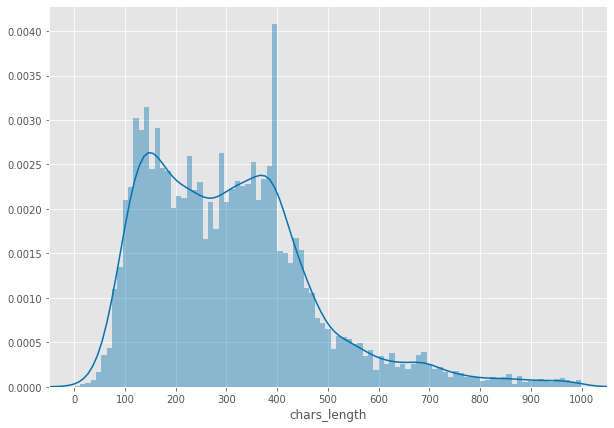

In [11]:
# Plot it with histogram
plt.figure(figsize=(10, 7))
sns.distplot(df['chars_length'], bins=int(np.sqrt(len(df))))
plt.xticks(np.arange(0, 1100, 100))
plt.xlim(-50, 1050);

Based on the graph above, the length of movie's overview mostly lie between 100 to 400 characters long, but some have 1000 characters long.

We have know about how many characters in each movie's overview. How about words length and sentence length? Let's explore more

In [12]:
df['words_length'] = df['overview'].apply(lambda x: len(word_tokenize(x)))
df['words_length'].head()

0    59
1    74
2    63
3    55
4    69
Name: words_length, dtype: int64

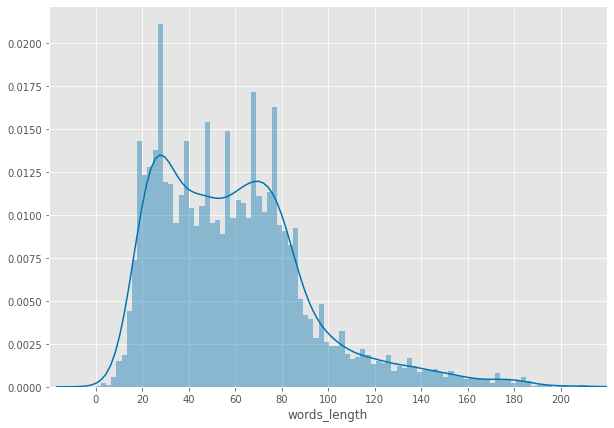

In [13]:
# Plot it with histogram
plt.figure(figsize=(10, 7))
sns.distplot(df['words_length'], bins=int(np.sqrt(len(df))))
plt.xticks(np.arange(0, 210, 20))
plt.xlim(-20, 220);

The shape of the plot not so different from the distribution plot of characters length. This time, mostly our data have words length from 20 to 80 words long.

In [14]:
df['sentences_length'] = df['overview'].apply(lambda x: len(sent_tokenize(x)))
df['sentences_length'].head()

0    3
1    2
2    3
3    2
4    2
Name: sentences_length, dtype: int64

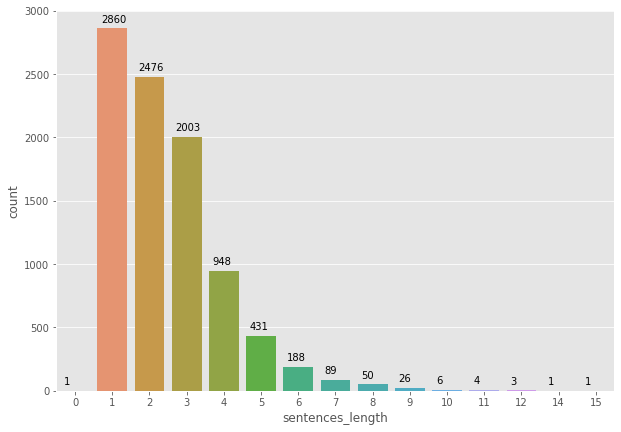

In [15]:
# Plot it with histogram
plt.figure(figsize=(10, 7))
ax = sns.countplot(df['sentences_length'])

for p in ax.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() + 0.1
    txt_y = p.get_height() + 50
    ax.text(txt_x, txt_y, txt);

Mostly the movie's overview just contain one sentence. But, notice that we have one data point with senteces length equals to 0. Certainly we have get rid of this in droping missing values earlier right?

In [16]:
df[df['sentences_length'] == 0]

,id,title,overview,tagline,chars_length,words_length,sentences_length
3657,49788,Slaves of New York,,NaN,1,0,0


In [17]:
df[df['words_length'] == 0]

,id,title,overview,tagline,chars_length,words_length,sentences_length
3657,49788,Slaves of New York,,NaN,1,0,0


In [18]:
df[df['chars_length'] == 1]

,id,title,overview,tagline,chars_length,words_length,sentences_length
3657,49788,Slaves of New York,,NaN,1,0,0


So problem is this data point contains only one white space and not coded as NaN in the first place. Then we have eliminate this data point.

In [19]:
df = df[~(df['words_length'] == 0)]

In [20]:
print('Current number of data points: ', len(df))

Current number of data points:  9086


In [21]:
df.index = np.arange(0, df.shape[0])
df = df.drop_duplicates(subset=['title'])

From 9099 data points at the begining, now we have eliminate 13 so we have 9086 data points now.

## Build Movies Recommendation (1)

This is the first attemp of building Movies Recommendation, we take raw data without much preprocessing or validating. Just run bag of words method to turn text data into matrix format.

In [22]:
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_count = count_vectorizer.fit_transform(df['overview'].values)
X_tfidf = tfidf_vectorizer.fit_transform(df['overview'].values)
titles = df['title']
print('Count Vectorized shape: ', X_count.shape)
print('Tfidf Vectorized shape: ', X_tfidf.shape)

Count Vectorized shape:  (8797, 29372)
Tfidf Vectorized shape:  (8797, 29372)


We have 29727 different words in our dataset, certainly a high dimensional dataset. Later we will see the difference we get if we do decrease the dimensionality.

In [23]:
similarity_tfidf = cosine_similarity(X_tfidf)
similarity_count = cosine_similarity(X_count)

We have the similarity matrices created by CountVectorizer and TfidfVectorizer. 

In [24]:
# Get the 10 most similar vectors
inds = similarity_tfidf[0].argsort()[-11:-1]
# Reverse from ascending to descending
inds = np.flip(inds)
list(df.iloc[inds]['title'].values)

['Toy Story 3',
 'Toy Story 2',
 'The 40 Year Old Virgin',
 'Rebel Without a Cause',
 'For Your Consideration',
 'Man on the Moon',
 'Malice',
 'Condorman',
 'Factory Girl',
 'Rivers and Tides']

On the example above, we put 0 as the index of Toy Story in similarity_tfidf matrix, and we get only 10 closest recommendations. Not so bad recommendations, is it? Now, to make things more easier, we create a corresponding function called get_recommendations. (Defined in helper function subsection)

In [25]:
indices = pd.Series(np.arange(0, df.shape[0]), index=df['title'])

In [26]:
get_recommendations('Batman', similarity_tfidf, indices)

['The Dark Knight Rises',
 'Batman: Under the Red Hood',
 'Batman Begins',
 'The Dark Knight',
 'Batman: The Dark Knight Returns, Part 1',
 'Batman Returns',
 'Batman: Year One',
 'Batman & Robin',
 'Batman: Mask of the Phantasm']

This is the recommendations we get if we want movies just like Batman.

## Movie Recommendation Using Movie's Plot